In [186]:
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
import utils.trick_output
importlib.reload(MLP)
importlib.reload(layer)
importlib.reload(utils.trick_output)
from MLP import MLP
from utils.preprocessing import split,Normalize
from utils.results import plot_results
from utils.regressor import regressor
from utils.trick_output import lin_sin_lin, trick_params
from scipy.optimize import curve_fit

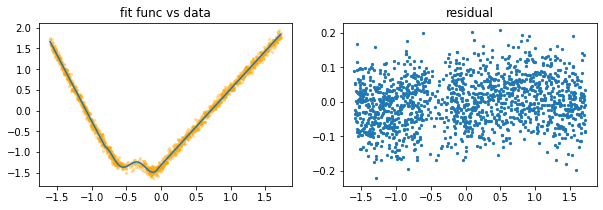

RMS = 2.704703265765484 (root sum of squared residual)


'kmax iteration reached'

In [188]:
raw_data=np.loadtxt(data_dir + "TR.csv",delimiter=",")[:,1:]
np.random.shuffle(raw_data)
normalizer_data = Normalize()
normalizer_labels = Normalize()
data = raw_data[:, :-2]
labels = raw_data[:, -2:]
norm_data = normalizer_data.normalize(data)
norm_labels = normalizer_labels.normalize(labels)

other_output= norm_labels[:,0]
lin_output= norm_labels[:,1]

x = np.copy(lin_output)
y = np.copy(other_output)

used_data = np.column_stack((norm_data, norm_labels))

xx = np.linspace(np.min(x), np.max(x), 1000)
params = trick_params(norm_name = 'std')

reg = regressor()
reg.fit(x, y, lin_sin_lin, params)
popt_sin = reg.best_params

fig, axs = plt.subplots(1, 2, figsize = (10, 3))
axs[0].plot(xx,lin_sin_lin(xx,*popt_sin))
axs[0].scatter(x, y, s = 5, label ='real', alpha = 0.3, c='orange')
axs[0].set_title('fit func vs data')
axs[1].scatter(x, y-lin_sin_lin(x,*popt_sin), s = 5)
axs[1].set_title('residual')
plt.show()
RMS = np.sqrt(np.sum((y-lin_sin_lin(x,*popt_sin))**2))
print(f'RMS = {RMS} (root sum of squared residual)')
reg.reason

In [230]:
input_data = used_data[:, :-2]
input_labels = used_data[:, -2:]

frac_test=0.01
data, test_set, labels, test_labels = split(input_data, input_labels, 
                                            kind="hold_out",frac_training=1-frac_test)

frac_training=0.8
training, validation, labels, val_labels=split(data, labels,kind="hold_out",
                                              frac_training=frac_training)

In [324]:
#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)

structure=[10, 5, labels.shape[-1]]
act_func=["sigmoid"]*(len(structure)-1) + ["linear"]
start=xavier(structure)

netw = MLP(structure, func=act_func,
           starting_points=start)

In [333]:
N_epoch = 10000
lamb=0.#1e-4
batch_size = 50 #-1 for batch gradient descent
alpha=5e-1
nesterov=True
eta_function=5e-4
beta=0.8
netw.train(training, labels, validation, val_labels,
           epoch = N_epoch,
           batch_size=batch_size,
           eta =eta_function, lamb = lamb,alpha=alpha,
           nesterov=nesterov,RMSProp=True,beta=beta, 
           error_threshold = 0.0, patience = 200, verbose = True)

Epoch 3588:  [train MEE = 0.2388]  [val MEE = 0.2582]                              
Elapsed time: 4.599933624267578 s


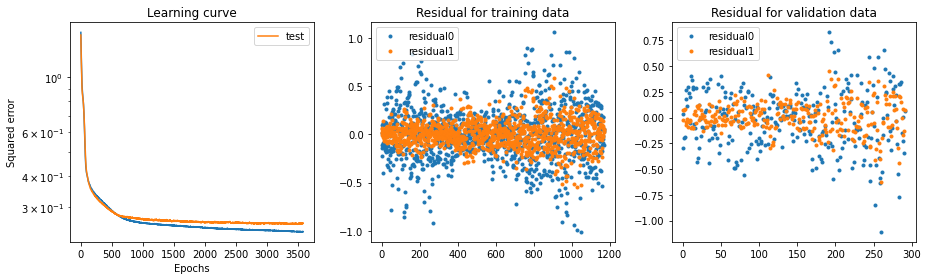

final train error: 0.23883914604486736
final val error: 0.2582480669410322


In [334]:
plot_results(netw, training, validation, labels, val_labels, sortidx = 1)

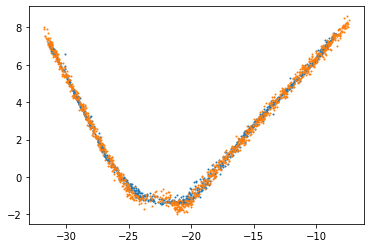

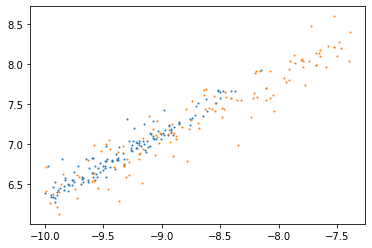

In [335]:
t_pred = netw.predict(training)
t_pred = normalizer_labels.denormalize(t_pred)

v_pred = netw.predict(validation)
v_pred = normalizer_labels.denormalize(v_pred)

ori_labels = normalizer_labels.denormalize(labels)
ori_val_labels = normalizer_labels.denormalize(val_labels)

plt.scatter(t_pred[:,1], t_pred[:,0], s = 1)
plt.scatter(ori_labels[:,1], ori_labels[:,0], s = 1)
plt.show()

zoom1 = -10
zoom2 = -5
m1 = t_pred[:, -1] < zoom2
m2 = t_pred[:, -1] > zoom1
zt_pred = t_pred[np.logical_and(m1, m2)]

m1 = ori_labels[:, -1] < zoom2
m2 = ori_labels[:, -1] > zoom1
z_labels = ori_labels[np.logical_and(m1, m2)]
plt.scatter(zt_pred[:, -1], zt_pred[:, -2], s = 1)
plt.scatter(z_labels[:, -1], z_labels[:, -2], s = 1)
plt.show()

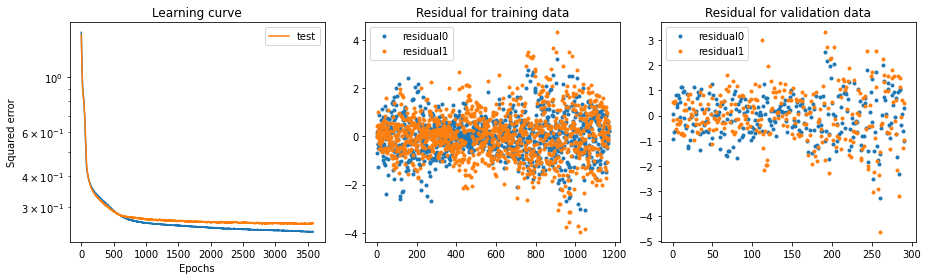

final train error: 1.0183036829468517
final val error: 1.0948322284355698


In [336]:
importlib.reload(utils.results)
from utils.results import plot_results
plot_results(netw, training, validation, ori_labels, ori_val_labels, norm = normalizer_labels.denormalize,
             func = lin_sin_lin, func_args = popt_sin, mean_fit = True, sortidx = 1)